# Higher-order Fluid Simulations on Periodic Boundaries with Φ<sub>Flow</sub>

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/docs/prerendered/HigherOrder_Demo.ipynb)

This notebook shows how to write a higher-order incompressible fluid simulation, simulating a Kolmogorov flow.
Higher-order finite difference schemes are available since Φ<sub>Flow</sub> 2.3.

**Warning:** Higher-order solvers are experimental in version 2.3. Only periodic boundary conditions are supported and the 6th-order implicit schemes does not yet support automatic matrix generation.


## Higher-order Schemes in Φ<sub>Flow</sub>

The spatial order of all built-in finite-difference functions is specified using the `order` parameter.
By default, an explicit finite difference scheme is used.
For implicit schemes, pass `implicit=Solve(...)` where the `Solve` specifies the algorithm and tolerances.

The following options are implemented up to date:


<table>
<thead>
  <tr>
    <th>Differential operation<br></th>
    <th>Supported Schemes</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>field.spatial_gradient,<br>field.laplace,<br>field.divergence</td>
    <td>order=2,<br>order=4,<br>order=6, implicit=Solve(...)<br></td>
  </tr>
  <tr>
    <td>advect.finite_difference,<br>diffuse.finite_difference</td>
    <td>order=2,<br>order=4,<br>order=6, implicit=Solve(...)</td>
  </tr>
  <tr>
    <td>fluid.make_incompressible</td>
    <td>order=2,<br>order=4</td>
  </tr>
  <tr>
    <td>Field.at</td>
    <td>order=2,<br>order=6, implicit=Solve(...) (only available for sampling at midpoints)<br></td>
  </tr>
</tbody>
</table>

If [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow) 2.3 or newer is not already installed, uncomment the first line in the cell below.

In [1]:
# !pip install --upgrade phiflow

from phi.jax.flow import *
from tqdm.notebook import trange

math.set_global_precision(64)

## Pressure Forcing
The Kolmogorov flow uses a sinusoidal forcing along x which is added to the velocity at every time step.
We add a small perturbation in the form of `Noise` to violate symmetry and trigger a turbulent time development.

<Figure size 864x360 with 4 Axes>

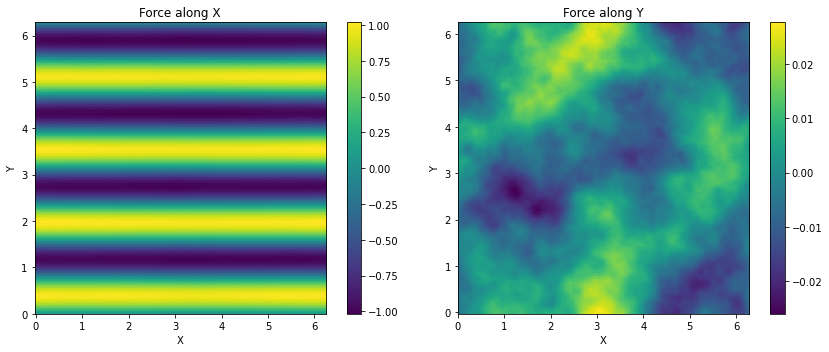

In [2]:
DOMAIN = dict(extrapolation=extrapolation.PERIODIC, bounds=Box(x=2*PI, y=2*PI), x=100, y=100)
FORCING = StaggeredGrid(lambda x, y: vec(x=math.sin(4 * y), y=0), **DOMAIN) + StaggeredGrid(Noise(), **DOMAIN) * 0.01
plot({'Force along X': FORCING['x'], 'Force along Y': FORCING['y']}, same_scale=False)

## Simulation
Next we define the momentum equation (PDE) for the incompressible flow.
We use 6th-order implicit advection and diffusion.
The pressure solve is integrated into Φ<sub>Flow</sub>'s 4th-order Runge-Kutta integrator `fluid.incompressible_rk4`. It uses a 4th-order direct scheme to avoid nested linear solves.
For all implicit operations, we use the conjugate gradient method `'CG'` since the periodic boundaries result in symmetric linear equation systems for which CG is fastest.

In [3]:
def momentum_equation(v, viscosity=0.001):
    advection = advect.finite_difference(v, v, order=6, implicit=Solve('CG', 1e-5, 1e-5))
    diffusion = diffuse.finite_difference(v, viscosity, order=6, implicit=Solve('CG', 1e-5, 1e-5))
    return advection + diffusion + FORCING

@jit_compile
def rk4_step(v, p, dt):
  return fluid.incompressible_rk4(momentum_equation, v, p, dt, pressure_order=4, pressure_solve=Solve('CG', 1e-5, 1e-5))

Let's run the simulation!

In [5]:
v0 = StaggeredGrid(0, **DOMAIN)
p0 = CenteredGrid(0, **DOMAIN)
multi_step = lambda *x, **kwargs: iterate(rk4_step, 25, *x, **kwargs)
v_trj, p_trj = iterate(multi_step, batch(time=100), v0, p0, dt=0.005, range=trange)
vis.plot(field.curl(v_trj.with_extrapolation(0)), animate='time')

<Figure size 432x288 with 0 Axes>

## Saving the Simulation Data

We can store the data in one of two ways: Either we use Φ<sub>Flow</sub>'s built-in field I/O functions, or we store the data using NumPy.
Let's view the NumPy data first.

In [6]:
np_velocity = v_trj.uniform_values().numpy('time,x,y,vector')
print(np_velocity.dtype, np_velocity.shape)

float64 (101, 100, 100, 2)


We can write this array using any of NumPy's save functions, such as `np.save, np.savez, np.savez_compressed`.
Note that we called `.uniform_values()` instead of `.values` to get an array that is guaranteed to be NumPy-compatible for all possible boundary conditions.

Alternatively, we can create a Φ<sub>Flow</sub> `Scene` object and write the data to it.

In [7]:
scene = Scene.create('data/')

scene.write(velocity_trj=v_trj, frame=0)  # write all frames into one file

for i, v_frame in enumerate(v_trj.time):  # write each frame into one file
    scene.write(velocity=v_frame, frame=i)

## Comparison to Lower-Order Schemes

An evaluation of accuracy and performance can be found [here](Taylor_Green_Comparison.html).